In [198]:
import numpy as np 
import numpy.ma as ma
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cbook as cbook
import matplotlib.colors as colors
import datetime

from tqdm import tqdm



import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy.io import fits
import glob
import pandas as pd
from astropy.table import Table

from ResidualUtils import getwavs#, getspecpath



matplotlib.rcParams.update({'xtick.labelsize':18,
                            'ytick.labelsize':18,
                            'axes.titlesize':18,
                            'axes.labelsize':18,
                            'font.size':18,
                            'xtick.top':True,
                            'xtick.minor.visible':True,
                            'ytick.minor.visible':True,
                            'xtick.major.size':4,
                            'xtick.minor.size':2,
                            'ytick.major.size':4,
                            'ytick.minor.size':2,
                            'ytick.right':True,
                            'xtick.direction':'in',
                            'ytick.direction':'in',
                            'font.family':'serif'})

flags = ['BADPIX',
'CRPIX',
'SATPIX',
'UNFIXABLE',
'BADDARK',
'BADFLAT',
'BADERR',
'NOSKY',
'LITTROW_GHOST',
'PERSIST_HIGH',
'PERSIST_MED',
'PERSIST_LOW',
'SIG_SKYLINE',
'SIG_TELLURIC']


from TolColors import tol_cmap
cmap = tol_cmap('rainbow_PuRd')
cmap_diverge = tol_cmap('sunset')

In [220]:
tabfile = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits'
stars = Table.read(tabfile, hdu = 1)

CA_fields = ['CA_161-06_btx', 'CA_161-06_btx', 'CA_162-11_btx', 'CA_163-05_btx', 'CA_163-08_btx',
             'CA_165-07_btx', 'CA_165-10_btx']
CA_inds = np.unique(np.concatenate([np.where(stars['FIELD'] == field)[0] for field in CA_fields]))
CA_stars = stars[CA_inds]
CA_clean = CA_stars[np.invert(np.logical_or.reduce([np.isnan(CA_stars['TEFF']), np.isnan(CA_stars['LOGG']), 
                                           np.isnan(CA_stars['M_H'])]))]

select_bitmasked = np.where((np.bitwise_and(stars['ASPCAPFLAG'], 23) == 0) | 
                            (np.bitwise_and(stars['ASPCAPFLAG'], 19) == 0))[0]

stars = stars[select_bitmasked]
stars = stars[np.where((stars['TEFF_ERR'] < 600) & (stars['LOGG_ERR'] < 0.5) & (stars['M_H_ERR'] < 0.3))[0]]
stars = stars[np.where(np.abs(stars['GLAT']) > 10)[0]]

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


In [200]:
meta = Table(fits.open('ResidualsFiles/meta_table.fits')[1].data)
active = np.where(meta['nstars'] > 0)[0]
morethan = meta[np.where(meta['nstars'] >= 2)[0]]

In [201]:
# res_std_median = np.zeros(active.shape)
# current_file = ''
# file = fits.open(meta['fname'][0])
# res_std_mean = np.zeros(active.shape)
# for num in tqdm(range(len(meta[active]))):
#     row = meta[active][num]
#     fname = row['fname']
#     if fname is not current_file:
#         file.close()
#         current_file = fname
#         file = fits.open(fname)[1:]
#         data = np.array(file).reshape(30,12)
#     j, k = (row['j'], row['k'])
#     hdu = data[j,k].data
#     res_std = hdu[2,:]
    
#     res_std_median[num] = np.nanmedian(res_std)
#     res_std_mean[num] = np.nanmean(res_std)
    
# #     print(res[0,:])

In [202]:
def get_residual(teff, logg, m_h):
    rowselect = np.where(np.logical_and.reduce([teff >= meta['teff_low'], teff < meta['teff_high'], 
                    logg >= meta['logg_low'], logg < meta['logg_high'],
                   m_h >= meta['m_h_low'], m_h < meta['m_h_high']]))[0]
    if len(rowselect) != 1:
        print('Wrong number of rows')
        return 
    
    
    row = meta[rowselect]
    j, k = (row['j'], row['k'])
    filename = row['fname'].item()
    hdulist = fits.open(filename)
    hdulist = np.array(hdulist)[1:].reshape(30,12)
    hdu = hdulist[j, k].item()
    return hdu

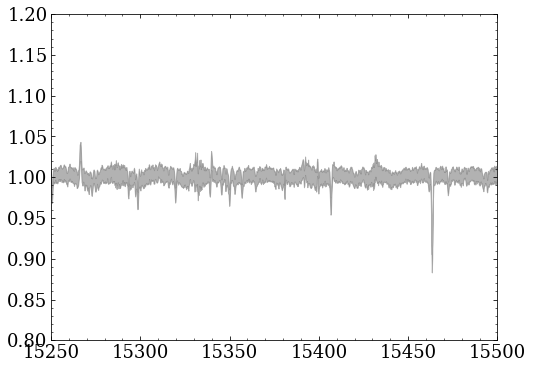

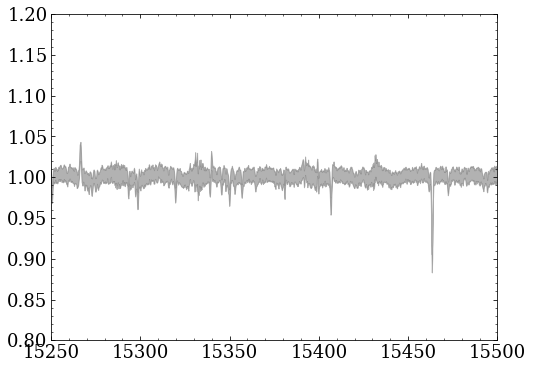

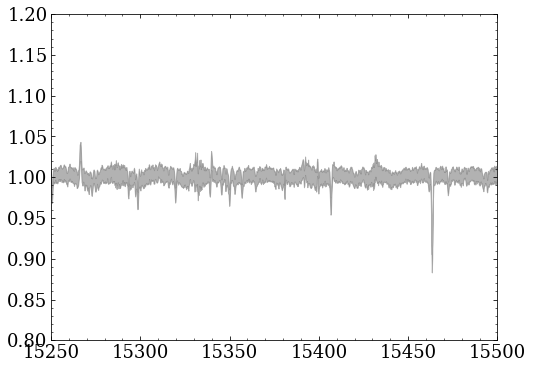

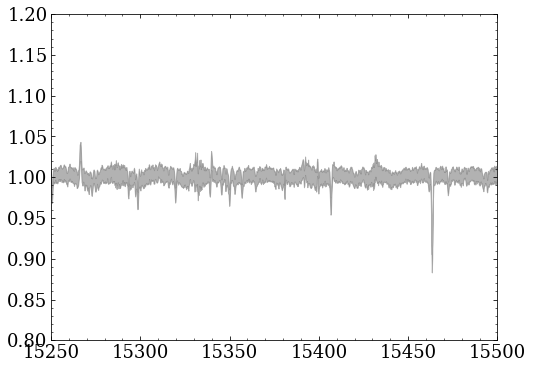

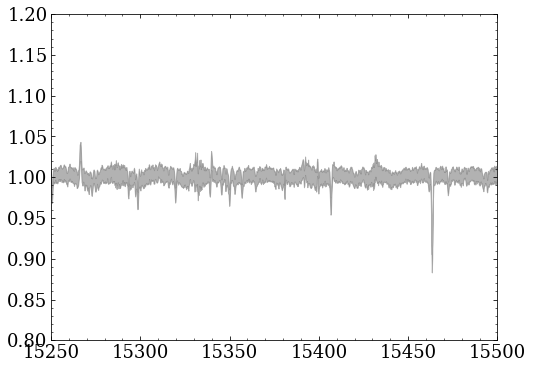

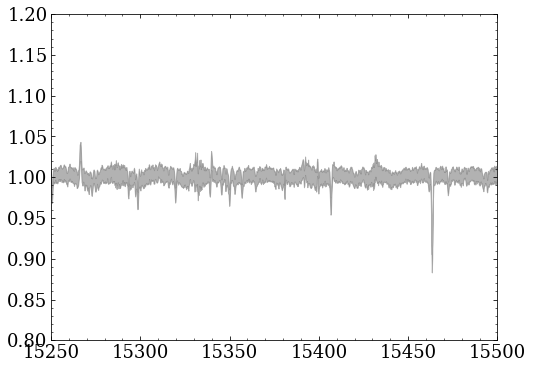

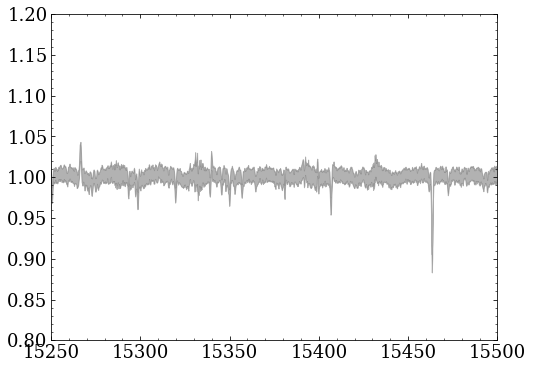

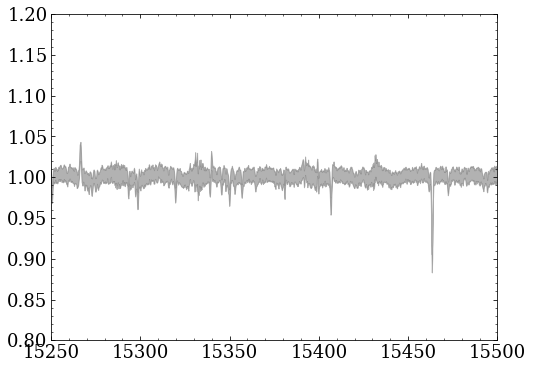

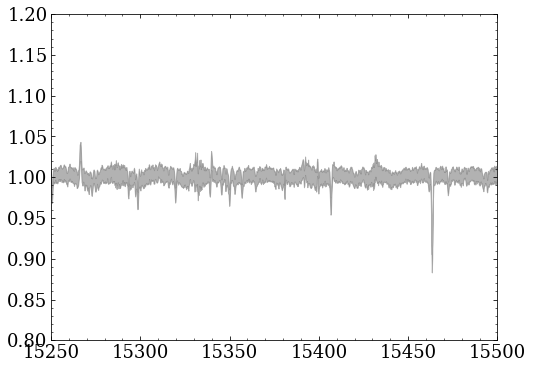

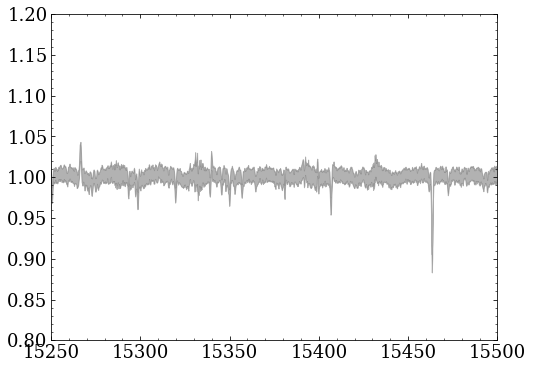

In [243]:
def getspecpath(row):
    specdir = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/{TELESCOPE}/{FIELD}/'
    specname = 'aspcapStar-dr17-{SOURCEID}.fits'
    telescope = np.array(row['TELESCOPE'], dtype = str)
    field = np.array(row['FIELD'], dtype = str)
    sourceid = np.array(row['APOGEE_ID'], dtype = str)
#     length = len(sourceid)
    path = (specdir + specname).format(TELESCOPE = telescope, FIELD = field, SOURCEID = sourceid)
    return path

for i in np.random.choice(len(CA_clean), size = 10):
    star = CA_clean[6]
    resdata = get_residual(star['TEFF'], star['LOGG'], star['M_H'])
    res = resdata.data[0,:]
    res_stdv = resdata.data[2,:]
    res_perc16 = resdata.data[4,:]
    res_perc84 = resdata.data[5,:]
    hdul = fits.open(getspecpath(star))
    wavs = getwavs(hdul)
    spec = hdul[1].data

    fig = plt.figure(figsize = (8,6))
    ax = plt.subplot()
#     ax.plot(wavs, spec)
#     ax.plot(wavs, res)
    ax.fill_between(wavs, res_perc84, res_perc16, color = 'grey', alpha = 0.6)
    ax.plot()

    ax.set_xlim(15250, 15500)
    ax.set_ylim(0.8, 1.2)

    plt.show()

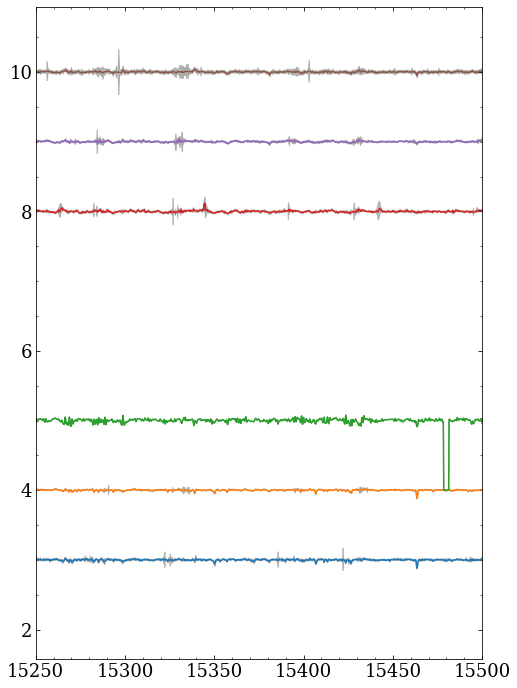

In [224]:
def thing():
    return

teff = 4000
logg = np.arange(0,5,0.5)

fig = plt.figure(figsize = (8, 12))
ax = plt.subplot()

for i in range(len(logg)):
    residual = get_residual(teff, logg[i], -.2)
    if residual.data is not None:
        ax.plot(wavs, residual.data[0,:] + i)
        ax.fill_between(wavs, residual.data[0,:] + i + residual.data[2,:], residual.data[0,:]+i-residual.data[2,:], color = 'grey', alpha = 0.5)
ax.set_xlim(15250, 15500)
# ax.set_ylim(0.8, 1.2)
plt.show()